<a href="https://colab.research.google.com/github/melvinfokam11/datasciencecoursera/blob/tp/Gauss_Newton.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import logging #This module defines functions and classes which implement a flexible event logging system for applications and libraries.
from typing import Callable

import numpy as np #
from numpy.linalg import pinv #for the calcul of inverse of the matrix

In [8]:
#initialize the logger
logger = logging.getLogger(__name__)

In [9]:
#define the class of gauss-newton solver

class GNSolver:
    """
    Gauss-Newton solver.
    Given response vector y, dependent variable x and fit function f, 
    Minimize sum(residual^2) where residual = f(x, coefficients) - y.
    """

    def __init__(self,
                 fit_function: Callable,
                 max_iter: int = 1000,
                 tolerance_difference: float = 10 ** (-16),
                 tolerance: float = 10 ** (-9),
                 init_guess: np.ndarray = None,
                 ):
        """
        :param fit_function: Function that needs be fitted; y_estimate = fit_function(x, coefficients).
        :param max_iter: Maximum number of iterations for optimization.
        :param tolerance_difference: Terminate iteration if RMSE difference between iterations smaller than tolerance.
        :param tolerance: Terminate iteration if RMSE is smaller than tolerance.
        :param init_guess: Initial guess for coefficients.
        """
        self.fit_function = fit_function
        self.max_iter = max_iter
        self.tolerance_difference = tolerance_difference
        self.tolerance = tolerance
        self.coefficients = None
        self.x = None
        self.y = None
        self.init_guess = None
        if init_guess is not None:
            self.init_guess = init_guess

    def fit(self,
            x: np.ndarray,
            y: np.ndarray,
            init_guess: np.ndarray = None) -> np.ndarray:
        """
        Fit coefficients by minimizing RMSE.
        :param x: Independent variable.
        :param y: Response vector.
        :param init_guess: Initial guess for coefficients.
        :return: Fitted coefficients.
        """

        self.x = x
        self.y = y
        if init_guess is not None:
            self.init_guess = init_guess

        if init_guess is None:
            raise Exception("Initial guess needs to be provided")

        self.coefficients = self.init_guess
        rmse_prev = np.inf
        for k in range(self.max_iter):
            residual = self.get_residual()
            jacobian = self._calculate_jacobian(self.coefficients, step=10 ** (-6))
            self.coefficients = self.coefficients - self._calculate_pseudoinverse(jacobian) @ residual
            rmse = np.sqrt(np.sum(residual ** 2))
            logger.info(f"Round {k}: RMSE {rmse}")
            if self.tolerance_difference is not None:
                diff = np.abs(rmse_prev - rmse)
                if diff < self.tolerance_difference:
                    logger.info("RMSE difference between iterations smaller than tolerance. Fit terminated.")
                    return self.coefficients
            if rmse < self.tolerance:
                logger.info("RMSE error smaller than tolerance. Fit terminated.")
                return self.coefficients
            rmse_prev = rmse
        logger.info("Max number of iterations reached. Fit didn't converge.")

        return self.coefficients

    def predict(self, x: np.ndarray):
        """
        Predict response for given x based on fitted coefficients.
        :param x: Independent variable.
        :return: Response vector.
        """
        return self.fit_function(x, self.coefficients)

    def get_residual(self) -> np.ndarray:
        """
        Get residual after fit.
        :return: Residual (y_fitted - y).
        """
        return self._calculate_residual(self.coefficients)

    def get_estimate(self) -> np.ndarray:
        """
        Get estimated response vector based on fit.
        :return: Response vector
        """
        return self.fit_function(self.x, self.coefficients)

    def _calculate_residual(self, coefficients: np.ndarray) -> np.ndarray:
        y_fit = self.fit_function(self.x, coefficients)
        return y_fit - self.y

    def _calculate_jacobian(self,
                            x0: np.ndarray,
                            step: float = 10 ** (-6)) -> np.ndarray:
        """
        Calculate Jacobian matrix numerically.
        J_ij = d(r_i)/d(x_j)
        """
        y0 = self._calculate_residual(x0)

        jacobian = []
        for i, parameter in enumerate(x0):
            x = x0.copy()
            x[i] += step
            y = self._calculate_residual(x)
            derivative = (y - y0) / step
            jacobian.append(derivative)
        jacobian = np.array(jacobian).T

        return jacobian

    @staticmethod
    def _calculate_pseudoinverse(x: np.ndarray) -> np.ndarray:
        """
        Moore-Penrose inverse.
        """
        return pinv(x.T @ x) @ x.T

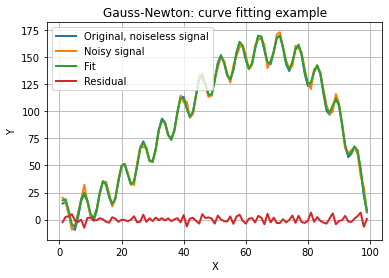

In [12]:
import logging

import matplotlib.pyplot as plt
import numpy as np

# from gn_solver import GNSolver

logging.basicConfig(level=logging.INFO)

NOISE = 3
COEFFICIENTS = [-0.001, 0.1, 0.1, 2, 15]


def func(x, coeff):
    return coeff[0] * x ** 3 + coeff[1] * x ** 2 + coeff[2] * x + coeff[3] + coeff[4] * np.sin(x)


def main():
    x = np.arange(1, 100)

    y = func(x, COEFFICIENTS)
    yn = y + NOISE * np.random.randn(len(x))

    solver = GNSolver(fit_function=func, max_iter=100, tolerance_difference=10 ** (-6))
    init_guess = 1000000 * np.random.random(len(COEFFICIENTS))
    _ = solver.fit(x, yn, init_guess)
    fit = solver.get_estimate()
    residual = solver.get_residual()

    plt.figure()
    plt.plot(x, y, label="Original, noiseless signal", linewidth=2)
    plt.plot(x, yn, label="Noisy signal", linewidth=2)
    plt.plot(x, fit, label="Fit", linewidth=2)
    plt.plot(x, residual, label="Residual", linewidth=2)
    plt.title("Gauss-Newton: curve fitting example")
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid()
    plt.legend()
    plt.show()


if __name__ == "__main__":
    main()